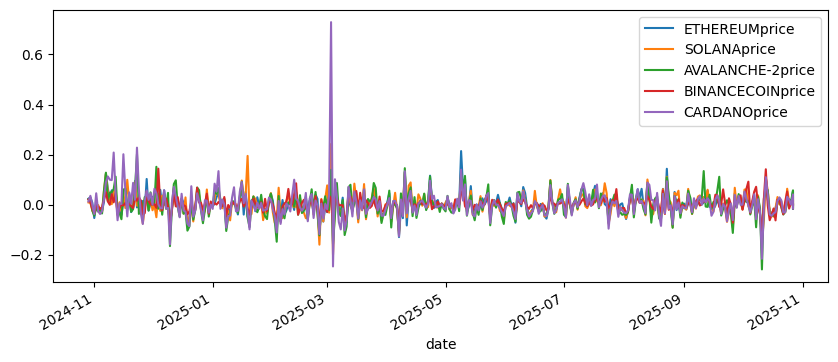

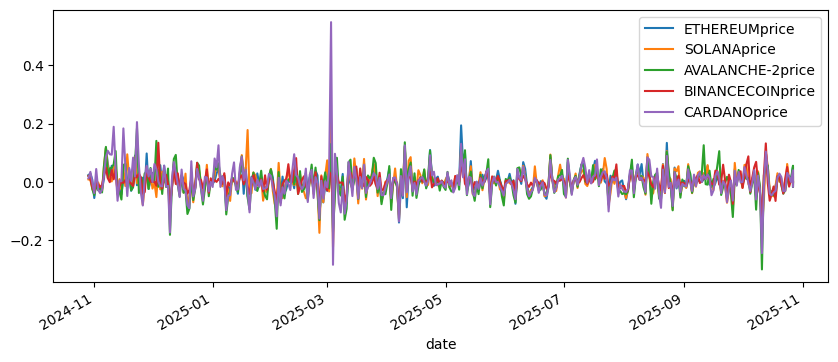

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

prices = pd.read_csv("data.csv", parse_dates=["date"])
prices.set_index("date", inplace=True)

# Make the plot bigger
plt.rcParams["figure.figsize"] = (10, 4)

returns = prices.pct_change().dropna(how="all")
# print(returns)

log_return = np.log(prices / prices.shift(1)).dropna(how="all")
# print(log_return)

returns.plot()
plt.show()
log_return.plot()
plt.show()



We model each token as a risky asset with daily returns. We will analyze mean, volatility, and downside risk from these return series.

In [17]:
## Some mathematical functions calculating different risk measures

ANNUAL = 252

def annual_return(returns):
    return returns.mean() * ANNUAL

def annual_volatility(returns):
    return returns.std() * np.sqrt(ANNUAL)

def sharpe_ratio(returns, rf_rate=0.00):
    std_daily = returns.std()
    if std_daily == 0 or np.isnan(std_daily):
      return np.nan
    return (annual_return(returns) - rf_rate) / annual_volatility(returns)


## This is a costly implementation of CVaR, which there is a equivalent calculation
## using linear programming that exe
def var(returns, alpha):
  return returns.quantile(alpha)

def cvar(returns, alpha):
  return returns[returns <= returns.quantile(alpha)].mean()




In [18]:
measurements = []

for col in returns.columns:
  series = returns[col].dropna()

  measurements.append({
      "Token":col,
      "Annual Return":annual_return(series),
      "Annual Volatility":annual_volatility(series),
      "Annual Sharpe Ratio":sharpe_ratio(series),
      "VaR_5pct_daily":var(series, alpha=0.05),
      "CVaR_5pct_daily":cvar(series, alpha=0.05)
  })

summary_df = pd.DataFrame(measurements)

## sort by Sharpe_ratio
summary_df.sort_values(by="Annual Sharpe Ratio", ascending=False, inplace=True)

print(summary_df)


              Token  Annual Return  Annual Volatility  Annual Sharpe Ratio  \
3  BINANCECOINprice       0.514883           0.431706             1.192673   
4      CARDANOprice       0.849999           0.967827             0.878256   
0     ETHEREUMprice       0.501035           0.612508             0.818005   
1       SOLANAprice       0.316149           0.697180             0.453468   
2  AVALANCHE-2price       0.164092           0.782427             0.209721   

   VaR_5pct_daily  CVaR_5pct_daily  
3       -0.039618        -0.059528  
4       -0.066828        -0.108094  
0       -0.054888        -0.081645  
1       -0.062488        -0.090453  
2       -0.073043        -0.112786  


Sample observations:

BInancecoin gives the best return per unit rate of risk.

A one-day 5% tail event for SOL historically means roughly 6% drawdown, and conditional drawdown is even worse at 9%

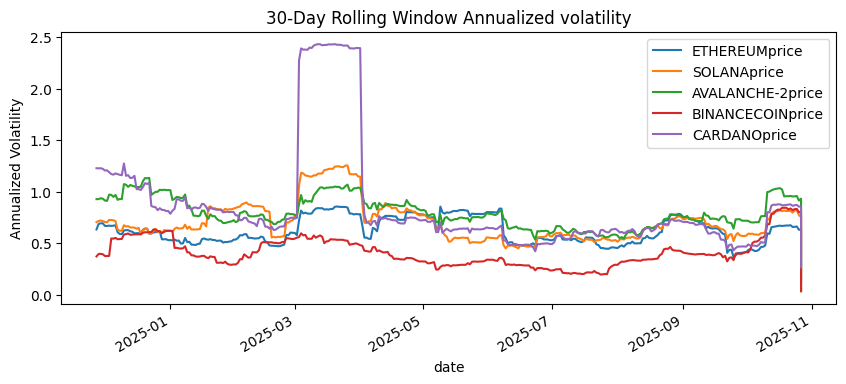

In [19]:
## Analyzing rolling (30 days) volatility annualized

rolling_vol = returns.rolling(window=30).std().dropna()*np.sqrt(ANNUAL)
rolling_vol.plot(title="30-Day Rolling Window Annualized volatility")
plt.ylabel("Annualized Volatility")
plt.show()